In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from scipy.stats import spearmanr
from statsmodels.graphics.tsaplots import plot_acf
import itertools
from itertools import product
import warnings
warnings.filterwarnings('ignore')  # 关闭所有警告

plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体为 SimHei
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号

In [2]:
# 读取 Excel 文件
file_path = 'data.xlsx'

# 查看文件内所有sheet名，确认需要读取的sheet
xls = pd.ExcelFile(file_path)
print("Sheet names:", xls.sheet_names)

Sheet names: ['收盘价', '自由流通换手率']


In [3]:
# 读取 sheet1
df = pd.read_excel(file_path, sheet_name='收盘价')

In [4]:
# 将第一列（日期列）重命名为 'date'
df.rename(columns={'Unnamed: 0': 'date'}, inplace=True)

# 将 'date' 转换为 datetime 格式
df['date'] = pd.to_datetime(df['date'])

# 设置为 index
df = df.set_index('date')

# 检查结果
print(df.head())
print(df.index)

               50收益  中证1000全收益     800收益
date                                    
2005-01-04  835.130    989.984  983.8953
2005-01-05  839.529   1013.583  995.5764
2005-01-06  830.513   1005.466  986.2162
2005-01-07  831.641   1011.740  987.6929
2005-01-10  841.102   1023.638  997.1864
DatetimeIndex(['2005-01-04', '2005-01-05', '2005-01-06', '2005-01-07',
               '2005-01-10', '2005-01-11', '2005-01-12', '2005-01-13',
               '2005-01-14', '2005-01-17',
               ...
               '2025-06-16', '2025-06-17', '2025-06-18', '2025-06-19',
               '2025-06-20', '2025-06-23', '2025-06-24', '2025-06-25',
               '2025-06-26', '2025-06-27'],
              dtype='datetime64[ns]', name='date', length=4974, freq=None)


超额净值曲线

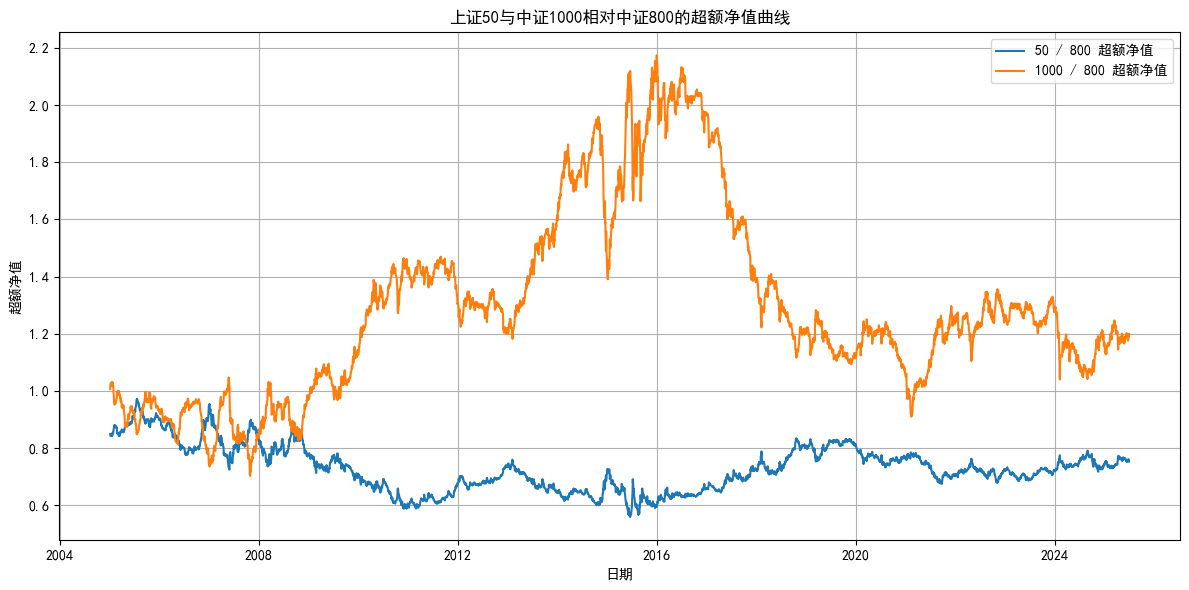

In [5]:
# 计算超额净值曲线
df['50_over_800'] = df['50收益'] / df['800收益']
df['1000_over_800'] = df['中证1000全收益'] / df['800收益']

# 画图
plt.figure(figsize=(12,6))
plt.plot(df.index, df['50_over_800'], label='50 / 800 超额净值')
plt.plot(df.index, df['1000_over_800'], label='1000 / 800 超额净值')

# 图表美化
plt.title('上证50与中证1000相对中证800的超额净值曲线')
plt.xlabel('日期')
plt.ylabel('超额净值')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 波动率策略

In [6]:
def volatility_strategy_monthly(df, window=20):
    """
    大小盘配置策略（月度调仓版）：纯波动率因子

    参数:
    - df: DataFrame，包含 '50收益' 和 '中证1000全收益' 两列（收盘价）
    - window: int，计算波动率的窗口期

    返回:
    - position_df: DataFrame，包含 'position_50' 和 'position_1000' 两列，二者加总为1
    """

    # === 1) 计算波动率 ===
    vol_50 = df['50收益'].pct_change().rolling(window).std()
    vol_1000 = df['中证1000全收益'].pct_change().rolling(window).std()

    # 避免除零错误
    epsilon = 1e-8
    inv_vol_50 = 1 / (vol_50 + epsilon)
    inv_vol_1000 = 1 / (vol_1000 + epsilon)
    total_inv_vol = inv_vol_50 + inv_vol_1000

    weight_50 = inv_vol_50 / total_inv_vol
    weight_1000 = inv_vol_1000 / total_inv_vol

    # === 2) 提取每月最后一个交易日 ===
    month_end_dates = df.resample('M').last().index

    # === 3) 初始化仓位 ===
    position_50 = pd.Series(index=df.index, dtype='float64')
    position_1000 = pd.Series(index=df.index, dtype='float64')

    # 初始默认仓位
    current_pos_50 = 0.5
    current_pos_1000 = 0.5

    # === 4) 根据信号更新仓位 ===
    for date in df.index:
        if date in month_end_dates:
            # 更新当月配置
            if not np.isnan(weight_50.loc[date]) and not np.isnan(weight_1000.loc[date]):
                current_pos_50 = weight_50.loc[date]
                current_pos_1000 = weight_1000.loc[date]

            # 归一化（数值稳定）
            total = current_pos_50 + current_pos_1000
            current_pos_50 /= total
            current_pos_1000 /= total

        position_50.loc[date] = current_pos_50
        position_1000.loc[date] = current_pos_1000

    position_df = pd.DataFrame({
        'position_50': position_50,
        'position_1000': position_1000
    }, index=df.index)

    return position_df

回测

In [7]:
# 获取策略每日仓位
position_df = volatility_strategy_monthly(df)

# =============================
# 计算每日组合收益率
# =============================
returns_50 = df['50收益'].pct_change()
returns_1000 = df['中证1000全收益'].pct_change()
portfolio_returns = position_df['position_50'] * returns_50 + position_df['position_1000'] * returns_1000
portfolio_returns = portfolio_returns.fillna(0)

# =============================
# 计算净值与超额净值曲线
# =============================
portfolio_nav = (1 + portfolio_returns).cumprod()
benchmark_nav = df['800收益'] / df['800收益'].iloc[0]
excess_nav = portfolio_nav / benchmark_nav

# =============================
# 计算回测指标
# =============================
annual_return = portfolio_nav.iloc[-1] ** (252 / len(portfolio_nav)) - 1
annual_vol = portfolio_returns.std() * np.sqrt(252)
sharpe_ratio = annual_return / annual_vol
max_drawdown = (portfolio_nav / portfolio_nav.cummax() - 1).min()
calmar_ratio = annual_return / abs(max_drawdown)

# =============================
# 输出结果
# =============================
print(f"【回测指标】")
print(f"年化收益率: {annual_return:.2%}")
print(f"年化波动率: {annual_vol:.2%}")
print(f"夏普比率: {sharpe_ratio:.2f}")
print(f"最大回撤: {max_drawdown:.2%}")
print(f"Calmar Ratio: {calmar_ratio:.2f}")

【回测指标】
年化收益率: 10.89%
年化波动率: 25.28%
夏普比率: 0.43
最大回撤: -70.86%
Calmar Ratio: 0.15


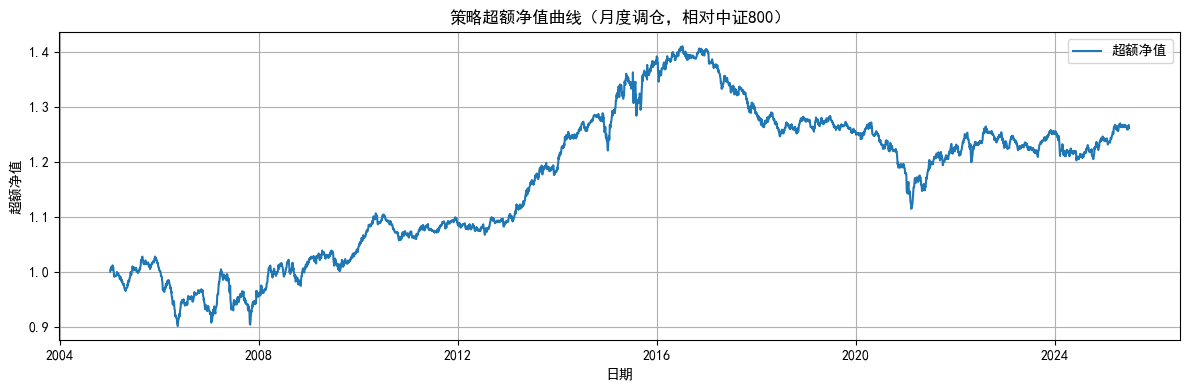

In [8]:
# 绘制超额净值曲线
plt.figure(figsize=(12,4))
plt.plot(excess_nav, label='超额净值')
plt.title('策略超额净值曲线（月度调仓，相对中证800）')
plt.xlabel('日期')
plt.ylabel('超额净值')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

参数优化

In [9]:
# 数据切分

# 前80%作为训练集，后20%作为测试集
split_index = int(len(df) * 0.6)
df_train = df.iloc[:split_index]
df_test = df.iloc[split_index:]

#在测试集上进行网格搜索
window_range = [10, 20, 30, 40, 50, 60]

results = []

for window in window_range:
    
    # 获取策略仓位（在训练集上）
    position_df = volatility_strategy_monthly(df_train, window=window)
    
    # 计算组合收益率
    returns_50 = df_train['50收益'].pct_change()
    returns_1000 = df_train['中证1000全收益'].pct_change()
    portfolio_returns = position_df['position_50'] * returns_50 + position_df['position_1000'] * returns_1000
    portfolio_returns = portfolio_returns.fillna(0)
    
    # 计算净值曲线
    portfolio_nav = (1 + portfolio_returns).cumprod()
    
    # 计算指标
    annual_return = portfolio_nav.iloc[-1] ** (252 / len(portfolio_nav)) - 1
    annual_vol = portfolio_returns.std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_vol
    max_drawdown = (portfolio_nav / portfolio_nav.cummax() - 1).min()
    calmar_ratio = annual_return / abs(max_drawdown)
    
    # 存储结果
    results.append({
        'window': window,
        'annual_return': annual_return,
        'annual_vol': annual_vol,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'calmar_ratio': calmar_ratio
    })

# =============================
# 输出Top 10
# =============================

results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by='calmar_ratio', ascending=False)

print("【最佳参数组合 Top 10 (按 Calmar Ratio 排序)】")
print(results_df_sorted.head(10))


【最佳参数组合 Top 10 (按 Calmar Ratio 排序)】
   window  annual_return  annual_vol  sharpe_ratio  max_drawdown  calmar_ratio
4      50       0.176083    0.287253      0.612989     -0.708038      0.248691
5      60       0.175612    0.287284      0.611286     -0.708292      0.247938
3      40       0.172515    0.287274      0.600526     -0.708575      0.243468
2      30       0.170378    0.287339      0.592953     -0.710069      0.239946
1      20       0.169980    0.287457      0.591325     -0.708593      0.239884
0      10       0.163453    0.287418      0.568694     -0.708933      0.230562


In [10]:
# =============================
# 数据切分
# =============================

split_index_train = int(len(df) * 0.65)
split_index_val = int(len(df) * 0.8)

df_train = df.iloc[:split_index_train]
df_val = df.iloc[split_index_train:split_index_val]  # 验证集（测试集1）
df_test = df.iloc[split_index_val:]  # 测试集2

# =============================
# 参数范围
# =============================

window_range = [5, 10, 20, 30, 40, 50, 60]

# =============================
# Grid Search on Training Set
# =============================

results = []

for window in window_range:
    
    # 获取策略仓位（在训练集上）
    position_df = volatility_strategy_monthly(
        df_train,
        window=window
    )
    
    # 计算组合收益率
    returns_50 = df_train['50收益'].pct_change()
    returns_1000 = df_train['中证1000全收益'].pct_change()
    portfolio_returns = position_df['position_50'] * returns_50 + position_df['position_1000'] * returns_1000
    portfolio_returns = portfolio_returns.fillna(0)
    
    # 计算净值曲线
    portfolio_nav = (1 + portfolio_returns).cumprod()
    
    # 计算指标
    annual_return = portfolio_nav.iloc[-1] ** (252 / len(portfolio_nav)) - 1
    annual_vol = portfolio_returns.std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_vol
    max_drawdown = (portfolio_nav / portfolio_nav.cummax() - 1).min()
    calmar_ratio = annual_return / abs(max_drawdown)
    
    # 存储结果
    results.append({
        'window': window,
        'annual_return': annual_return,
        'annual_vol': annual_vol,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'calmar_ratio': calmar_ratio
    })

# =============================
# 输出 Top 10
# =============================

results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by='calmar_ratio', ascending=False)

print("【最佳参数组合 Top 10 (按 Calmar Ratio 排序)】")
print(results_df_sorted.head(10))

【最佳参数组合 Top 10 (按 Calmar Ratio 排序)】
   window  annual_return  annual_vol  sharpe_ratio  max_drawdown  calmar_ratio
0       5       0.167090    0.278571      0.599811     -0.702309      0.237915
5      50       0.165528    0.278219      0.594957     -0.708038      0.233785
6      60       0.165012    0.278245      0.593046     -0.708292      0.232972
4      40       0.161511    0.278252      0.580448     -0.708575      0.227938
2      20       0.158603    0.278437      0.569621     -0.708593      0.223829
3      30       0.158742    0.278336      0.570324     -0.710069      0.223558
1      10       0.152847    0.278457      0.548906     -0.708933      0.215601


In [11]:
# =============================
# 验证集（测试集1）评估
# =============================

best_params = results_df_sorted.iloc[0]

position_val = volatility_strategy_monthly(
    df_val,
    window=int(best_params['window'])
)

returns_50_val = df_val['50收益'].pct_change()
returns_1000_val = df_val['中证1000全收益'].pct_change()
portfolio_returns_val = position_val['position_50'] * returns_50_val + position_val['position_1000'] * returns_1000_val
portfolio_returns_val = portfolio_returns_val.fillna(0)
portfolio_nav_val = (1 + portfolio_returns_val).cumprod()

annual_return_val = portfolio_nav_val.iloc[-1] ** (252 / len(portfolio_nav_val)) - 1
annual_vol_val = portfolio_returns_val.std() * np.sqrt(252)
sharpe_ratio_val = annual_return_val / annual_vol_val
max_drawdown_val = (portfolio_nav_val / portfolio_nav_val.cummax() - 1).min()
calmar_ratio_val = annual_return_val / abs(max_drawdown_val)

print("\n【验证集（测试集1）表现】")
print(f"年化收益率: {annual_return_val:.2%}")
print(f"年化波动率: {annual_vol_val:.2%}")
print(f"夏普比率: {sharpe_ratio_val:.2f}")
print(f"最大回撤: {max_drawdown_val:.2%}")
print(f"Calmar Ratio: {calmar_ratio_val:.2f}")


【验证集（测试集1）表现】
年化收益率: 8.59%
年化波动率: 21.43%
夏普比率: 0.40
最大回撤: -24.62%
Calmar Ratio: 0.35


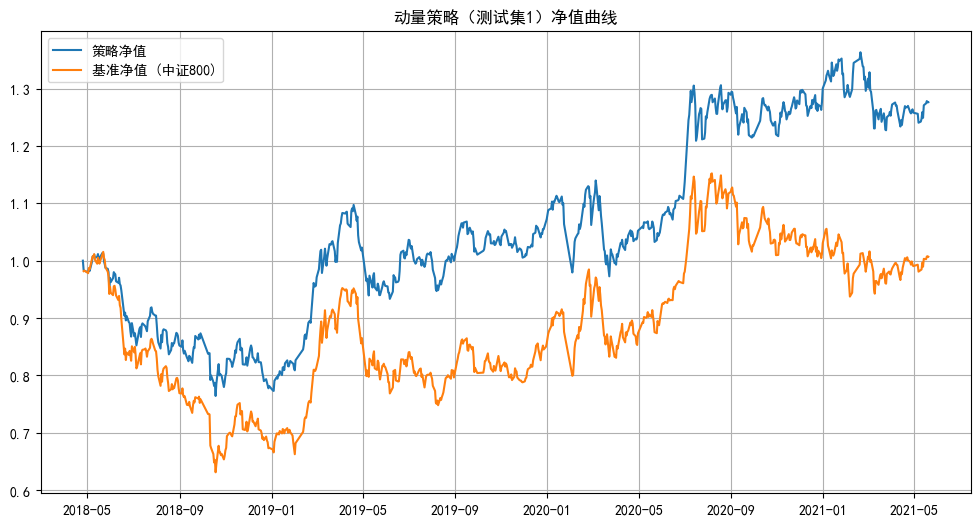

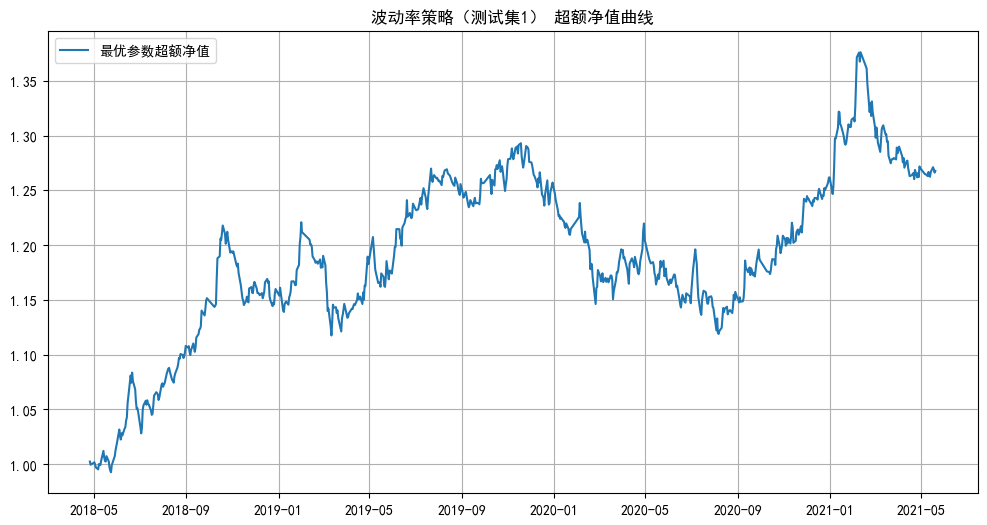

In [15]:
# 计算基准（例如中证1000）净值曲线
benchmark_nav_val = (1 + returns_1000_val).cumprod()

# 计算超额净值曲线
excess_nav_val = portfolio_nav_val / benchmark_nav_val


# 绘制策略 vs 基准净值曲线
plt.figure(figsize=(12,6))
plt.plot(portfolio_nav_val.index, portfolio_nav_val, label='策略净值')
plt.plot(benchmark_nav_val.index, benchmark_nav_val, label='基准净值 (中证800)')
plt.title('动量策略（测试集1）净值曲线')
plt.legend()
plt.grid(True)
plt.show()

# 绘制超额净值曲线
plt.figure(figsize=(12,6))
plt.plot(excess_nav_val.index, excess_nav_val, label='最优参数超额净值')
plt.title('波动率策略（测试集1） 超额净值曲线')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# =============================
# 测试集2 评估
# =============================

position_test2 = volatility_strategy_monthly(
    df_test,
    window=int(best_params['window'])
)

returns_50_test2 = df_test['50收益'].pct_change()
returns_1000_test2 = df_test['中证1000全收益'].pct_change()
portfolio_returns_test2 = position_test2['position_50'] * returns_50_test2 + position_test2['position_1000'] * returns_1000_test2
portfolio_returns_test2 = portfolio_returns_test2.fillna(0)
portfolio_nav_test2 = (1 + portfolio_returns_test2).cumprod()

annual_return_test2 = portfolio_nav_test2.iloc[-1] ** (252 / len(portfolio_nav_test2)) - 1
annual_vol_test2 = portfolio_returns_test2.std() * np.sqrt(252)
sharpe_ratio_test2 = annual_return_test2 / annual_vol_test2
max_drawdown_test2 = (portfolio_nav_test2 / portfolio_nav_test2.cummax() - 1).min()
calmar_ratio_test2 = annual_return_test2 / abs(max_drawdown_test2)

print("\n【测试集2（最终测试集）表现】")
print(f"年化收益率: {annual_return_test2:.2%}")
print(f"年化波动率: {annual_vol_test2:.2%}")
print(f"夏普比率: {sharpe_ratio_test2:.2f}")
print(f"最大回撤: {max_drawdown_test2:.2%}")
print(f"Calmar Ratio: {calmar_ratio_test2:.2f}")


【测试集2（最终测试集）表现】
年化收益率: -2.18%
年化波动率: 18.39%
夏普比率: -0.12
最大回撤: -36.94%
Calmar Ratio: -0.06


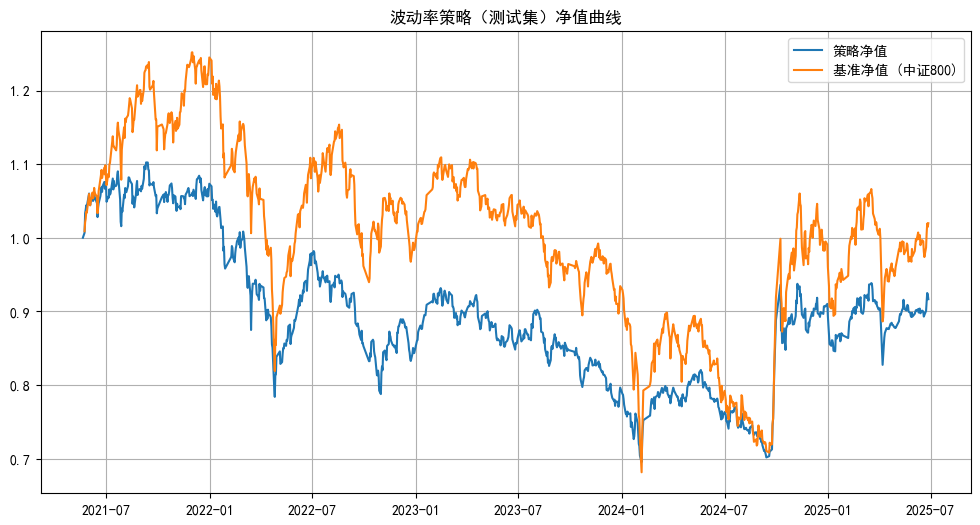

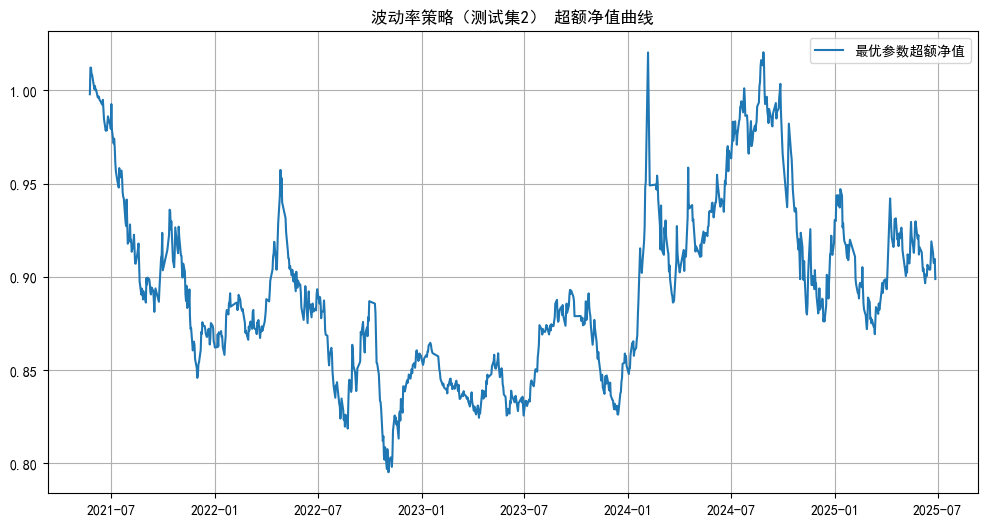

In [16]:
benchmark_nav_test2 = (1 + returns_1000_test2).cumprod()

# 计算超额净值曲线
excess_nav_test2 = portfolio_nav_test2 / benchmark_nav_test2


# 绘制策略 vs 基准净值曲线
plt.figure(figsize=(12,6))
plt.plot(portfolio_nav_test2.index, portfolio_nav_test2, label='策略净值')
plt.plot(benchmark_nav_test2.index, benchmark_nav_test2, label='基准净值 (中证800)')
plt.title('波动率策略（测试集）净值曲线')
plt.legend()
plt.grid(True)
plt.show()

# 绘制超额净值曲线
plt.figure(figsize=(12,6))
plt.plot(excess_nav_test2.index, excess_nav_test2, label='最优参数超额净值')
plt.title('波动率策略（测试集2） 超额净值曲线')
plt.legend()
plt.grid(True)
plt.show()